# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




**Instructions for the assignment**

1.YOU HAVE TO DOWNLOAD ONLY THESE NOTEBOOKS(check the drive link attached), WRITE YOUR CODE IN THE SAME NOTEBOOKS AND UPLOAD AS YOUR SUBMISSION.

2. There are two tasks of KNN clearly mentioned in the ipynb. One is to apply Brute force KNN and other is KD-tree version of KNN. You have to perform both these tasks on all 4 vectorizers. (BOW, TFIDF, AVG-W2V, TFIDF-AVG_W2V)
3. If you have 4GB of RAM then consider 50k points as sample size for brute force algorithm and 20k as sample size for kd-tree algorithm. If your RAM is 8GB then consider a minimum sample size of 100k datapoints for brute force and 20k datapoints for kd-tree algorithm. And if your RAM is less than 4GB then please upgrade your RAM to a minimum of 8GB.
4. You can use sparse matrices for brute force algorithm of KNN.
5. For kd-tree algorithm you have to use dense matrices. Please note that if you pass sparse matrix as input to kd-tree algorithm then by default it will run in brute-force. So please use dense matrices for kd-tree.
6. Use AUC as a metric for hyperparameter tuning.
7. Properly document the results according to the instructions provided in the corresponding ipynb.
8. If you want to further increase the performance of the model, you can experiment with the feature engineering section mentioned in the ipynb.


**Steps**
1. Import data
2. Preprocessing the data
3. Split data into train and test data sets
4. Take care of data leakage by not fitting - transform the entrire data
5. Apply the knn brute force algorithm
6. Apply the kd tree algorithm

**Blogs to read**
* [sklearn doc on nn](https://scikit-learn.org/stable/modules/neighbors.html)
* [knn classifier](https://medium.com/machine-learning-101/k-nearest-neighbors-classifier-1c1ff404d265) knn and kdtree
* [SO CV](https://stats.stackexchange.com/questions/52274/how-to-choose-a-predictive-model-after-k-fold-cross-validation#answer-52277) Very good explanation on importance of cv
* [How to Train a Final Machine Learning Model](https://machinelearningmastery.com/train-final-machine-learning-model/) puts light on CV

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pickle
from tqdm import tqdm
import os
from collections import Counter

# ============================== loading libraries ===========================================

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.feature_extraction.text import CountVectorizer


C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import os
print(os.listdir("."))

['.ipynb_checkpoints', '01 adv py template.ipynb', '03 Amazon Fine Food Reviews Analysis_KNN.ipynb', '04 Amazon Fine Food Reviews Analysis_NaiveBayes.ipynb', '3d_plot.JPG', 'Amazon knn  resubmission.ipynb', 'Amazon KNN-Copy1.ipynb', 'Amazon KNN.ipynb', 'Assignment 22 SQL', 'Comparing gridsearch and randomizedsearch for finding hyperparameter.ipynb', 'confusion_matrix.png', 'database.sqlite', 'demo_data', 'finalized_df.sav', 'finalized_model.sav', 'Functions for knn.ipynb', 'heat_map.JPG', 'Itertools tutorial.ipynb', 'kfold.ipynb', 'knn', 'knn practice 1- kd.ipynb', 'knn practice 1.ipynb', 'knn-20190220T090416Z-001.zip', 'knn.ipynb', 'pickle.ipynb', 'preprocessed_final', 'python collections.ipynb', 'summary.JPG', 'train_cv_auc.JPG', 'train_test_auc.JPG', 'Untitled.ipynb']


## Applying KNN Brute Force: Data Import and Preprocessing

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite')

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

In [4]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

In [5]:
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

In [6]:
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [7]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [8]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [9]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [10]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [12]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [13]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [14]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [15]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [16]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [17]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...


In [18]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

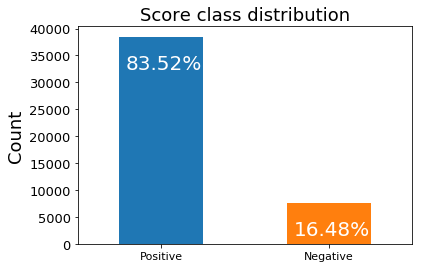

In [19]:
# Code referred from https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
ax = final['Score'].value_counts().plot(kind='bar', 
                                         fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Score class distribution", fontsize=18)
ax.set_ylabel("Count", fontsize=18);
#ax.set_yticks([0, 5, 10, 15, 20])
ax.set_xticklabels(['Positive', 'Negative'], rotation=0, fontsize=11)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # Decreasing the i.get_x()+.12 will shift the text to left side and decreasing the i.get_height()-14 will bring the text down
    ax.text(i.get_x()+.04, i.get_height()-6000, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=20,
                color='white')


**Observation:** This is an imbalance dataset. There are roughly 84% Positive review and 16% Negative reviews.

*Checkpoint 1: Imported data and some basic eda*

In [20]:
# Filtering 1 (positive) and 0 (negative) reviews
#pos_reviews = final[final['Score'] == 1].sample(n=10000, random_state=507)
#neg_reviews = final[final['Score'] == 0].sample(n=10000, random_state=507)

# Combining the above dataframes into one
#final = pd.concat([pos_reviews, neg_reviews])

In [21]:
# Converting Time to time format in seconds using a unix epoch time
# We will arrange the entire final dataframe in ascending order for time based splitting

final["Time"] = pd.to_datetime(final["Time"], origin='unix', unit = "s")
final = final.sort_values(by = "Time")

In [22]:
final.size

460710

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [23]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
Speaking as another Texan, I think the first rule for these delicious treats is to NOT order them during spring or summer. In fact, your safest bet is to ONLY order them in the dead of winter.  LOL!  As long as you do that, be prepared for a truly amazing treat!  This package comes with 12 bite-sized delicacies.  The chocolate is high-quality, the nuts are crunchy, and the overall taste couldn't be better.  Definitely worth the price!
Fast, easy and definitely delicious.  Makes a great cup of coffee and very easy to make.  Good purchase.  Will continue to order from here.<br />Thanx...
Naturally this review is based upon my cat's intake of Petite Cuisine. She's not a particular picky eater, so I can't say much about that. However, she looks to really enjoy this brand of cat food. I have tried some brands of wet food in 

In [24]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [25]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
Speaking as another Texan, I think the first rule for these delicious treats is to NOT order them during spring or summer. In fact, your safest bet is to ONLY order them in the dead of winter.  LOL!  As long as you do that, be prepared for a truly amazing treat!  This package comes with 12 bite-sized delicacies.  The chocolate is high-quality, the nuts are crunchy, and the overall taste couldn't be better.  Definitely worth the price!
Fast, easy and definitely delicious.  Makes a great cup of coffee and very easy to make.  Good purchase.  Will continue to order from here.Thanx...
Naturally this review is based upon my cat's intake of Petite Cuisine. She's not a particular picky eater, so I can't say much about that. However, she looks to really enjoy this brand of cat food. I have tried some brands of wet food in the pa

In [26]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [27]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Fast, easy and definitely delicious.  Makes a great cup of coffee and very easy to make.  Good purchase.  Will continue to order from here.<br />Thanx...


In [28]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [29]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Fast easy and definitely delicious Makes a great cup of coffee and very easy to make Good purchase Will continue to order from here br Thanx 


In [30]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [31]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46071/46071 [00:13<00:00, 3488.12it/s]


In [32]:
preprocessed_reviews[1500]

'fast easy definitely delicious makes great cup coffee easy make good purchase continue order thanx'

<h2>[3.2] Preprocessing Review Summary</h2>

In [33]:
## Similartly you can do preprocessing for review summary also.
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())


 57%|█████████████████████████████████████████████████████████████████████▎                                                    | 26170/46071 [00:04<00:03, 5640.67it/s]C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46071/46071 [00:08<00:00, 5555.36it/s]


In [34]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,2000-06-23,Great Product,This was a really good idea and the final prod...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,2003-10-25,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe..."
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,2003-10-25,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...
38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,1,2003-10-31,These limes rule!,"Fresh limes are underappreciated, but a joy to..."


In [35]:
final['CleanedText']= preprocessed_reviews
final['CleanedSummary']= preprocessed_summary

In [36]:
final.CleanedText.isnull().sum()

0

In [37]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,2000-06-23,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...,great product
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...,wow make islickers
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,2003-10-25,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",nothing product bother link top page buy used ...,chewed gum many times used
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,2003-10-25,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,love stuff sugar free not rot gums tastes good...,best sugarless gum ever
38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,1,2003-10-31,These limes rule!,"Fresh limes are underappreciated, but a joy to...",fresh limes underappreciated joy kitchen squir...,limes rule


In [38]:
import pickle

In [39]:
file_Name = "preprocessed_final"
# open the file for writing
fileObject = open(file_Name,'wb') 

# this writes the object a to the
# file named 'testfile'
pickle.dump(final,fileObject)

 *Checkpoint 2: Data is now sorted based on Time and preprocessed.*

In [40]:
# Create X and Y variable 
X = final['CleanedText'].values
y= final['Score'].values

In [41]:
type(X)

numpy.ndarray

In [42]:
type(y)

numpy.ndarray

In [43]:
# ss
from sklearn.model_selection import train_test_split

# Splitting into train and test in the ratio 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,shuffle=False, random_state=507)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.30, shuffle=False, random_state=507)

In [44]:
# ss
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


(22574,) (22574,)
(9675,) (9675,)
(13822,) (13822,)


In [45]:
print("Train Set:",X_train.shape, y_train.shape[0])
print("Test Set:",X_test.shape, y_test.shape[0])

Train Set: (22574,) 22574
Test Set: (13822,) 13822


*Checkpoint 3: Data has been partioned into train, cv and test*

# [4.1] BAG OF WORDS

In [46]:
# ss
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(22574, 28400) (22574,)
(9675, 28400) (9675,)
(13822, 28400) (13822,)


In [47]:
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of cut text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words: ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of cut text BOW vectorizer  (22574, 28400)
the number of unique words:  28400


## 1. KNN Brute Force algorithm implementation on BOW 

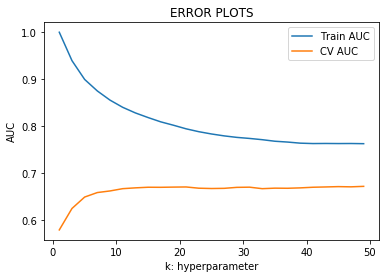

In [48]:
# ss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

#K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in neighbors:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
    neigh.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(neighbors, train_auc, label='Train AUC')
plt.plot(neighbors, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [49]:
# ss
# changing to misclassification error
MSE = [1 - x for x in cv_auc]


# determining best k
optimal_k_bow_bf = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_bow_bf)


The optimal number of neighbors is 49.


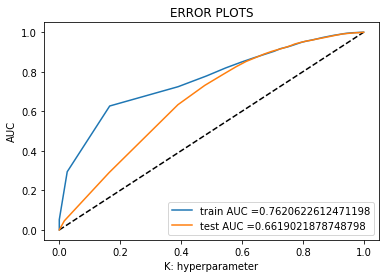

Train confusion matrix
[[  183  3156]
 [   98 19137]]
Test confusion matrix
[[  150  2379]
 [   80 11213]]


In [50]:
## ss

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=optimal_k_bow_bf, algorithm='brute')
neigh.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow)[:,1])

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_bow)))

In [51]:
auc_train_bow_bf = auc(train_fpr, train_tpr)
auc_test_bow_bf = auc(test_fpr, test_tpr)

In [52]:
# Get the confusion matrix
from sklearn.metrics import classification_report


# Code modified from sklearn tutorial: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if normalize:
     #   cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     #   print("Normalized confusion matrix")
    #else:
      #  print('Confusion matrix')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


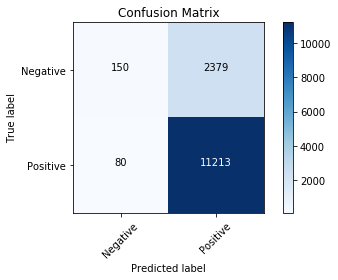

In [53]:
cnf_matrix = confusion_matrix(y_test, neigh.predict(X_test_bow))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix');

## [4.2] Bi-Grams and n-Grams.

In [54]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
#count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
#final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
#print("the type of count vectorizer ",type(final_bigram_counts))
#print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
#print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [55]:
# ss
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(22574, 13749) (22574,)
(9675, 13749) (9675,)
(13822, 13749) (13822,)


In [56]:
print("the type of count vectorizer ",type(X_train_tfidf))
print("the shape of cut text BOW vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words: ", X_train_tfidf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of cut text BOW vectorizer  (22574, 13749)
the number of unique words:  13749


## 2. KNN Brute Force algorithm implementation on TF-IDF 

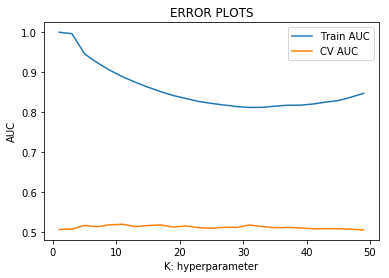

In [57]:
# ss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

#K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in neighbors:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute')    
    neigh.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(neighbors, train_auc, label='Train AUC')
plt.plot(neighbors, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [58]:
# changing to misclassification error
MSE= [1 - x for x in cv_auc]

# determining best k
optimal_k_tfidf_bf = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_tfidf_bf)


The optimal number of neighbors is 11.


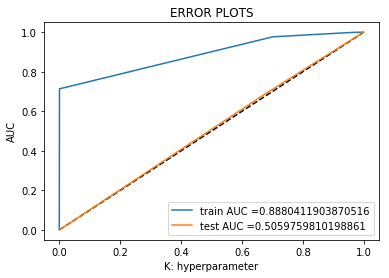

Train confusion matrix
[[    1  3338]
 [    0 19235]]
Test confusion matrix
[[    0  2529]
 [    0 11293]]


In [59]:
## ss

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=optimal_k_tfidf_bf, algorithm='brute')
neigh.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_tfidf)[:,1])

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_tfidf)))

In [60]:
auc_train_tfidf_bf = auc(train_fpr, train_tpr)
auc_test_tfidf_bf = auc(test_fpr, test_tpr)

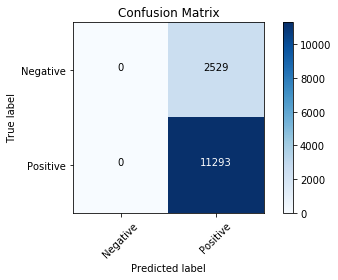

In [61]:
cnf_matrix = confusion_matrix(y_test, neigh.predict(X_test_tfidf))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix');

**H. Observations:**
1. For the TF-IDF vectorizer , using the brute force implementation, the optimal k used was 9 and it gave a test accuracy of 83.51%
2. As the number of k reached 9, the MSE came down sharply.
3. The confusion matrix shows poor classification of our model.
4. The AUC for train and test is quite far away from each other and also the auc test is poor.

## [4.4] Word2Vec

In [62]:
# Train your own Word2Vec model using your own text corpus 
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [63]:
print(list_of_sentance_train[0])

['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'decals', 'car', 'window', 'everybody', 'asks', 'bought', 'decals', 'made', 'two', 'thumbs']


In [64]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8231831789016724), ('good', 0.809023916721344), ('fantastic', 0.8033546209335327), ('wonderful', 0.8007094264030457), ('excellent', 0.7858836650848389), ('terrific', 0.7624676823616028), ('perfect', 0.7576509714126587), ('amazing', 0.7421754598617554), ('decent', 0.6955416798591614), ('nice', 0.6583067178726196)]
[('best', 0.8094383478164673), ('tastiest', 0.7711542844772339), ('nastiest', 0.7426066398620605), ('ever', 0.7398572564125061), ('greatest', 0.733481228351593), ('softest', 0.7298107147216797), ('closest', 0.7284467220306396), ('ive', 0.7268621921539307), ('hottest', 0.7198749780654907), ('eaten', 0.6891652345657349)]


In [65]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9128
sample words  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'nothing', 'bother', 'link', 'top', 'page', 'buy']


**Converting train text data**

In [66]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22574/22574 [00:27<00:00, 822.56it/s]


(22574, 50)
[-0.37  0.09  0.27  0.15  0.41  0.24 -0.46  0.02  0.31 -0.07  0.07  0.36
 -0.09 -0.32  0.2  -0.14 -0.41  0.35  0.13 -0.59  0.3   0.6  -0.13  0.04
  0.27  0.36 -0.04  0.06 -0.07 -0.44  0.63 -0.08 -0.64 -0.17 -0.18 -0.37
 -0.32  0.4  -0.24  0.32  0.2  -0.47  0.07 -0.06 -0.14  0.46  0.2  -0.47
 -0.07  0.19]


**Converting cv text data**

In [67]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [68]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9675/9675 [00:11<00:00, 823.46it/s]


(9675, 50)
[-0.11  0.43 -0.04  0.25  0.44  0.15 -0.33  0.21  0.48 -0.04 -0.06  0.51
 -0.31  0.08 -0.01 -0.45 -0.41  0.1  -0.1  -0.38  0.45  0.78 -0.04  0.32
  0.5   0.14 -0.17  0.17 -0.18 -0.04  0.38  0.36 -0.62 -0.2  -0.38 -0.53
 -0.72  0.16 -0.43  0.11 -0.06 -0.42 -0.15 -0.12 -0.09  0.6   0.05 -0.47
 -0.    0.3 ]


**Converting test text data**

In [69]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [70]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13822/13822 [00:16<00:00, 860.52it/s]


(13822, 50)
[-0.08  0.07  0.37  0.28  0.23 -0.49 -0.85  0.24  0.67 -0.59 -0.61  0.93
 -0.88  0.64 -0.22 -0.85 -0.14 -0.18  0.09 -0.63  0.38  1.38 -0.15  0.25
  0.41 -0.48  0.37  0.96 -0.31 -0.22  0.7   0.42 -0.91 -0.44  0.2  -1.34
 -0.87 -0.48 -0.45 -0.23 -0.06 -0.84 -0.22  0.17 -0.66  0.76  0.5  -0.95
 -0.05 -0.08]


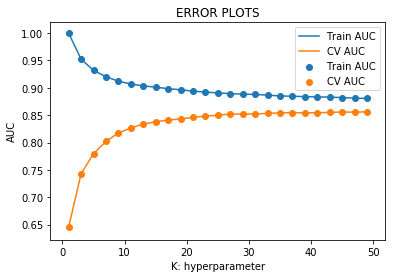

In [71]:
train_auc = []
cv_auc = []

myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

#K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in neighbors:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm = 'brute')
    neigh.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  neigh.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(neighbors, train_auc, label='Train AUC')
plt.scatter(neighbors, train_auc, label='Train AUC')
plt.plot(neighbors, cv_auc, label='CV AUC')
plt.scatter(neighbors, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

## 3. KNN Brute Force algorithm implementation on Avg-W2V 

In [72]:
# changing to misclassification error
MSE = [1 - x for x in cv_auc]

# determining best k
optimal_k_avgw2v_bf = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_avgw2v_bf)


The optimal number of neighbors is 49.


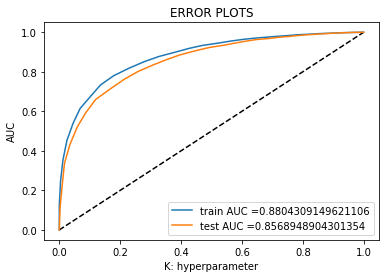

Train confusion matrix
[[  547  2792]
 [  168 19067]]
Test confusion matrix
[[  412  2117]
 [  121 11172]]


In [73]:
## ss

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=optimal_k_avgw2v_bf, algorithm='brute')
neigh.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(sent_vectors_test)[:,1])

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(sent_vectors_test)))

In [74]:
auc_train_avgw2v_bf = auc(train_fpr, train_tpr)  #auc_train_avgw2v_bf
auc_test_avgw2v_bf = auc(test_fpr, test_tpr)

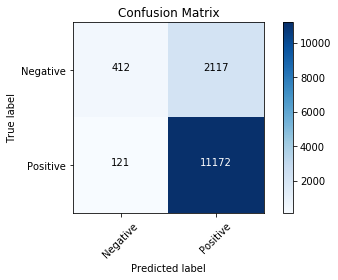

In [75]:
cnf_matrix = confusion_matrix(y_test, neigh.predict(sent_vectors_test))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix');

#### [4.4.1.2] TFIDF weighted W2v

In [76]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
X_train_tf_idf_w2v = model.fit_transform(X_train)
X_test_tf_idf_w2v = model.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [77]:
# TF-IDF weighted Word2Vec for sentences in X_train
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22574/22574 [04:08<00:00, 90.68it/s]


In [78]:
# TF-IDF weighted Word2Vec for sentences in X_test
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9675/9675 [01:41<00:00, 95.47it/s]


In [79]:
# TF-IDF weighted Word2Vec for sentences in X_test
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13822/13822 [02:32<00:00, 90.85it/s]


## 4. KNN Brute Force algorithm implementation on TFIDF-W2V 

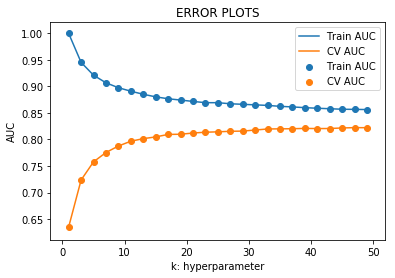

In [80]:
train_auc = []
cv_auc = []

myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

#K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in neighbors:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm = 'brute')
    neigh.fit(tfidf_sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(tfidf_sent_vectors_train)[:,1]
    y_cv_pred =  neigh.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(neighbors, train_auc, label='Train AUC')
plt.scatter(neighbors, train_auc, label='Train AUC')
plt.plot(neighbors, cv_auc, label='CV AUC')
plt.scatter(neighbors, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [81]:
# changing to misclassification error
MSE= [1 - x for x in cv_auc]

# determining best k
optimal_k_tfidfavgw2v_bf = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_tfidfavgw2v_bf)


The optimal number of neighbors is 47.


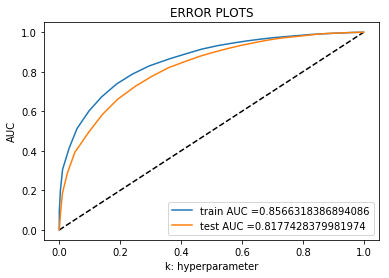

Train confusion matrix
[[  399  2940]
 [  131 19104]]
Test confusion matrix
[[  319  2210]
 [   76 11217]]


In [82]:
## ss

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=optimal_k_tfidfavgw2v_bf, algorithm='brute')
neigh.fit(tfidf_sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(tfidf_sent_vectors_test)))

In [83]:
auc_train_tfidfw2v_bf = auc(train_fpr, train_tpr)
auc_test_tfidfw2v_bf = auc(test_fpr, test_tpr)

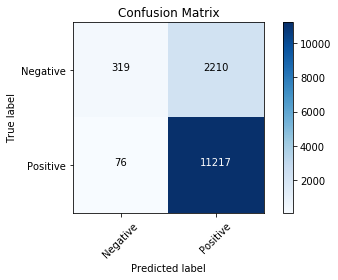

In [84]:
cnf_matrix = confusion_matrix(y_test, neigh.predict(tfidf_sent_vectors_test))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix');

## Applying KNN kd tree: Data Import and Preprocessing

**Free-up variables that are occupying space and are not needed**

In [85]:
del final, preprocessed_reviews

del X, y, sorted_data, sent_vectors_cv, sent_vectors_test, sent_vectors_train

del tfidf_sent_vectors_train, tfidf_sent_vectors_cv, tfidf_sent_vectors_test

del list_of_sentance_cv, list_of_sentance_test, list_of_sentance_train

del dictionary, filtered_data, actualScore, sent_0, sent_1000, sent_150, sent_1500, sent_4900, stopwords, tfidf_feat, w2v_words

In [86]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 20000""", con) 

In [87]:
def partition(x):
    if x < 3:
        return 0
    return 1

In [88]:
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (20000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [89]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [90]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(19354, 10)

In [91]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

96.77

In [92]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [93]:
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(19354, 10)


1    16339
0     3015
Name: Score, dtype: int64

In [94]:
final["Time"] = pd.to_datetime(final["Time"], origin='unix', unit = "s")
final = final.sort_values(by = "Time")

In [95]:
final.size

193540

In [96]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
THIS COFFEE IS REALLY DELICIOUS.A COOL LATIN FLAVOR.EXCELLENT.5 STARS I GIVE TO THIS COFFEE.I HOPE AMAZON NEVER GET RID OF IT BECAUSE THIS COFFEE IS REALLY HARD TO FIND IN MY LOCAL SUPERMARKETS.AND I HPE ALWAYS THEY GOT THE SAME LOW PRICE FOR 6 PACKETS.THE LESS I GET THIS COFFEE BAGS IS $2.49 PER PACKET.GOOD DEAL,AMAZON.HURRAY FOR YOU.
I use this product frequently.  Like most tofu, you need to press it (between paper towels with a heavy skillet on top works fine) to get the excess water out.  The more water you can remove, the less you'll have to deal with sloppiness when cooking, something the previous reviewer did not like.<br /><br />As for a blank slate on taste, that's exactly what makes tofu great.  It will take on any flavor you want to impart.  Our most common marinade is placing the pressed, cubed tofu in a Zi

In [97]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [98]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [99]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19354/19354 [00:05<00:00, 3370.89it/s]


In [100]:
final['CleanedText']= preprocessed_reviews

In [101]:
final.CleanedText.isnull().sum()

0

In [102]:
# Create X and Y variable 
X = final['CleanedText'].values
y= final['Score'].values

In [103]:
from sklearn.model_selection import train_test_split
# Splitting into train and test in the ratio 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,shuffle=False, random_state=507)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.30, shuffle=False, random_state=507)

In [104]:
print("Train Set:",X_train.shape[0], y_train.shape[0])
print("CV Set:",X_cv.shape[0], y_cv.shape[0])
print("Test Set:",X_test.shape[0], y_test.shape[0])

Train Set: 9482 9482
CV Set: 4065 4065
Test Set: 5807 5807


## 5. KNN KD-Tree implementation on BoW 

In [105]:
# ss
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10, max_features=500)
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(9482, 500) (9482,)
(4065, 500) (4065,)
(5807, 500) (5807,)


In [106]:
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of cut text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words: ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of cut text BOW vectorizer  (9482, 500)
the number of unique words:  500


In [107]:
# Converting sparse matrix to dense 
X_train_bow = X_train_bow.todense()
X_cv_bow = X_cv_bow.todense()
X_test_bow = X_test_bow.todense()

In [108]:
print("the type of count vectorizer ",type(X_train_bow))

the type of count vectorizer  <class 'numpy.matrixlib.defmatrix.matrix'>


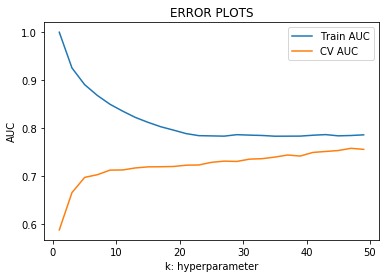

In [109]:
# ss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

#K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in neighbors:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    neigh.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(neighbors, train_auc, label='Train AUC')
plt.plot(neighbors, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [110]:
# ss
# changing to misclassification error
MSE = [1 - x for x in cv_auc]


# determining best k
optimal_k_bow_kd = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_bow_kd)


The optimal number of neighbors is 47.


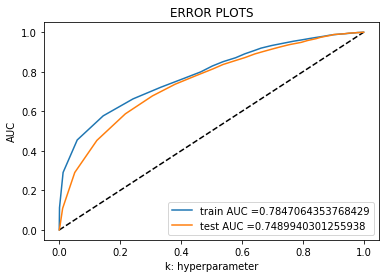

Train confusion matrix
[[ 135 1223]
 [ 103 8021]]
Test confusion matrix
[[  99  905]
 [  55 4748]]


In [111]:
neigh = KNeighborsClassifier(n_neighbors=optimal_k_bow_kd, algorithm='kd_tree')
neigh.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow)[:,1])

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_bow)))

In [112]:
auc_train_bow_kd = auc(train_fpr, train_tpr)
auc_test_bow_kd = auc(test_fpr, test_tpr)

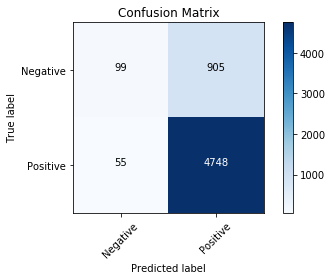

In [113]:
cnf_matrix = confusion_matrix(y_test, neigh.predict(X_test_bow))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix');

## 6. KNN KD-Tree implementation on TF-IDF 

In [114]:
# ss
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(9482, 500) (9482,)
(4065, 500) (4065,)
(5807, 500) (5807,)


In [115]:
# Converting sparse matrix to dense 
X_train_tfidf = X_train_tfidf.todense()
X_cv_tfidf = X_cv_tfidf.todense()
X_test_tfidf = X_test_tfidf.todense()

In [116]:
type(X_train_tfidf)

numpy.matrixlib.defmatrix.matrix

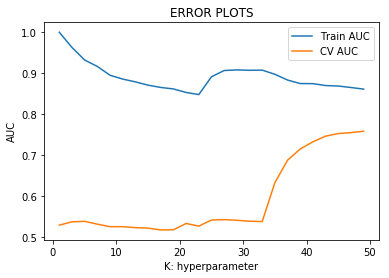

In [117]:
# ss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

#K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in neighbors:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')    
    neigh.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(neighbors, train_auc, label='Train AUC')
plt.plot(neighbors, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [118]:
# changing to misclassification error
MSE= [1 - x for x in cv_auc]

# determining best k
optimal_k_tfidf_kd = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_tfidf_kd)


The optimal number of neighbors is 49.


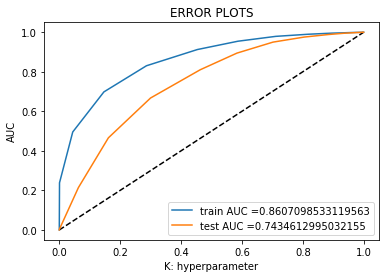

Train confusion matrix
[[   0 1358]
 [   0 8124]]
Test confusion matrix
[[   0 1004]
 [   0 4803]]


In [119]:
## ss

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=optimal_k_tfidf_kd, algorithm='kd_tree')
neigh.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_tfidf)[:,1])

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_tfidf)))

In [120]:
auc_train_tfidf_kd = auc(train_fpr, train_tpr)
auc_test_tfidf_kd = auc(test_fpr, test_tpr)

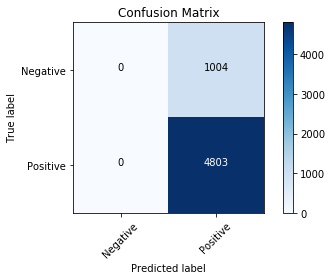

In [121]:
cnf_matrix = confusion_matrix(y_test, neigh.predict(X_test_tfidf))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix');

## [4.4] Word2Vec

In [122]:
# Train your own Word2Vec model using your own text corpus 
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [123]:
print(list_of_sentance_train[0])

['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'decals', 'car', 'window', 'everybody', 'asks', 'bought', 'decals', 'made', 'two', 'thumbs']


In [124]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8621622323989868), ('excellent', 0.8588515520095825), ('wonderful', 0.7883070111274719), ('quick', 0.7698708772659302), ('awesome', 0.7666758298873901), ('especially', 0.7547547221183777), ('makes', 0.7517443895339966), ('super', 0.7501925826072693), ('fantastic', 0.7384480237960815), ('tasty', 0.7362213134765625)]
[('hooked', 0.9825462102890015), ('amongst', 0.9818435311317444), ('absolute', 0.9788781404495239), ('dunkin', 0.9782604575157166), ('shortbread', 0.9753953814506531), ('varieties', 0.9747499823570251), ('among', 0.9743835926055908), ('favorites', 0.9742165207862854), ('hands', 0.9703830480575562), ('decadence', 0.9692540764808655)]


In [125]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5964
sample words  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'chatchi', 'favorite', 'afternoon', 'treat', 'became', 'unavailable', 'vending']


**Converting train text data**

In [126]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9482/9482 [00:08<00:00, 1148.83it/s]


(9482, 50)
[-0.19  0.01  0.19  0.02  0.24  0.32 -0.25  0.17  0.06 -0.18 -0.07  0.34
 -0.18 -0.15  0.08 -0.09 -0.15  0.19 -0.26 -0.27  0.3   0.7  -0.26  0.25
  0.35  0.15  0.04  0.24 -0.38 -0.25  0.57  0.24 -0.5  -0.21 -0.34 -0.43
 -0.46  0.28 -0.04  0.17  0.1  -0.29 -0.   -0.27  0.25  0.47  0.06 -0.62
 -0.24  0.06]


**Converting cv text data**

In [127]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [128]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4065/4065 [00:03<00:00, 1183.42it/s]


(4065, 50)
[-0.19  0.08  0.12  0.07  0.24  0.3  -0.36  0.12  0.39 -0.36 -0.19  0.44
 -0.22 -0.19 -0.18 -0.58 -0.33 -0.21 -0.18 -0.46  0.5   1.06 -0.24  0.27
  0.37  0.16 -0.09  0.25 -0.47 -0.34  0.64  0.71 -0.73 -0.16 -0.45 -0.76
 -0.68 -0.12 -0.19  0.19  0.05 -0.48 -0.04 -0.43  0.3   0.32  0.39 -0.81
 -0.48  0.15]


**Converting test text data**

In [129]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [130]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5807/5807 [00:04<00:00, 1227.73it/s]


(5807, 50)
[ 0.03  0.1  -0.08  0.06  0.42  0.39 -0.77  0.27 -0.17 -0.04  0.13  0.54
 -0.18 -0.22  0.03 -0.54 -0.4  -0.18 -0.29 -0.08  0.21  1.23 -0.14  0.2
  0.53  0.22 -0.34  0.11 -0.4  -0.49  0.8   0.49 -0.72  0.02 -0.95 -0.61
 -0.86  0.25 -0.14  0.52 -0.11 -0.38 -0.01 -0.17  0.17  0.76  0.19 -0.81
 -0.23  0.07]


## 7. KNN KD-Tree implementation on AVG W2V 

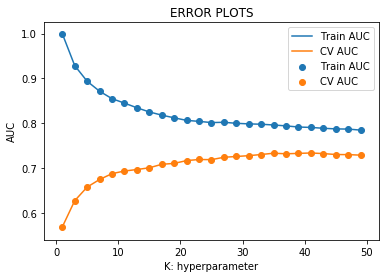

In [131]:
train_auc = []
cv_auc = []

myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

#K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in neighbors:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm = 'kd_tree')
    neigh.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  neigh.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(neighbors, train_auc, label='Train AUC')
plt.scatter(neighbors, train_auc, label='Train AUC')
plt.plot(neighbors, cv_auc, label='CV AUC')
plt.scatter(neighbors, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [132]:
# changing to misclassification error
MSE = [1 - x for x in cv_auc]

# determining best k
optimal_k_avgw2v_kd = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_avgw2v_kd)


The optimal number of neighbors is 41.


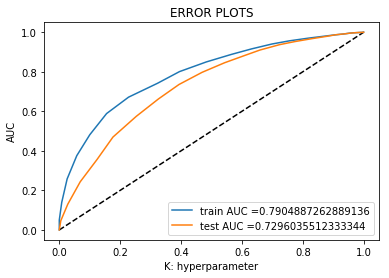

Train confusion matrix
[[  27 1331]
 [  15 8109]]
Test confusion matrix
[[  17  987]
 [   6 4797]]


In [133]:
## ss

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=optimal_k_avgw2v_kd, algorithm='kd_tree')
neigh.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(sent_vectors_test)[:,1])

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(sent_vectors_test)))

In [134]:
auc_train_avgw2v_kd = auc(train_fpr, train_tpr)
auc_test_avgw2v_kd = auc(test_fpr, test_tpr)

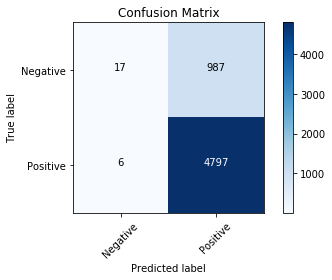

In [135]:
cnf_matrix = confusion_matrix(y_test, neigh.predict(sent_vectors_test))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix');

## 8. KNN KD-Tree implementation on TFIDF-W2V 

In [136]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
X_train_tf_idf_w2v = model.fit_transform(X_train)
X_test_tf_idf_w2v = model.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [137]:
# TF-IDF weighted Word2Vec for sentences in X_train
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9482/9482 [00:56<00:00, 166.55it/s]


In [138]:
# TF-IDF weighted Word2Vec for sentences in X_test
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4065/4065 [00:22<00:00, 176.76it/s]


In [139]:
# TF-IDF weighted Word2Vec for sentences in X_test
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5807/5807 [00:32<00:00, 180.48it/s]


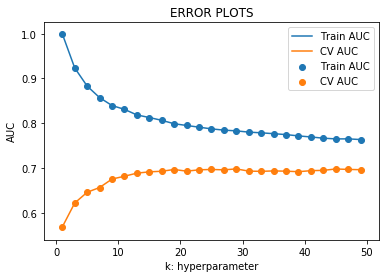

In [140]:
train_auc = []
cv_auc = []

myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

#K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in neighbors:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm = 'kd_tree')
    neigh.fit(tfidf_sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(tfidf_sent_vectors_train)[:,1]
    y_cv_pred =  neigh.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(neighbors, train_auc, label='Train AUC')
plt.scatter(neighbors, train_auc, label='Train AUC')
plt.plot(neighbors, cv_auc, label='CV AUC')
plt.scatter(neighbors, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [141]:
# changing to misclassification error
MSE= [1 - x for x in cv_auc]

# determining best k
optimal_k_tfidfavgw2v_kd = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_tfidfavgw2v_kd)


The optimal number of neighbors is 29.


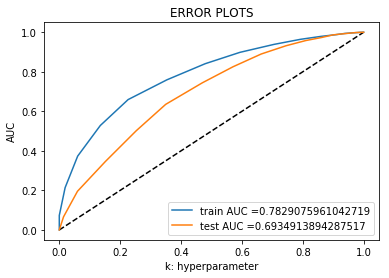

Train confusion matrix
[[  30 1328]
 [  15 8109]]
Test confusion matrix
[[  26  978]
 [   8 4795]]


In [142]:
## ss

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=optimal_k_tfidfavgw2v_kd, algorithm='kd_tree')
neigh.fit(tfidf_sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(tfidf_sent_vectors_test)))

In [143]:
auc_train_tfidfw2v_kd = auc(train_fpr, train_tpr)
auc_test_tfidfw2v_kd = auc(test_fpr, test_tpr)

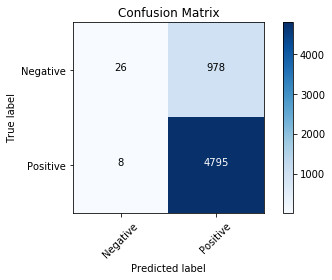

In [144]:
cnf_matrix = confusion_matrix(y_test, neigh.predict(tfidf_sent_vectors_test))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix');

# Conclusions

In [145]:
from prettytable import PrettyTable

In [146]:
t1 = PrettyTable()

In [147]:
t2 = PrettyTable()

In [148]:
t1.field_names = ['Sr. No', 'Algorithm','k-fold cv','Number of Data Points']
t1.add_row([1, 'Brute Force', 5, 50000])
t1.add_row([2, 'KD Tree', 5, 20000])
print(t1)

+--------+-------------+-----------+-----------------------+
| Sr. No |  Algorithm  | k-fold cv | Number of Data Points |
+--------+-------------+-----------+-----------------------+
|   1    | Brute Force |     5     |         50000         |
|   2    |   KD Tree   |     5     |         20000         |
+--------+-------------+-----------+-----------------------+


In [149]:
t2.field_names = ['Sr. No', 'Vectorizer', 'Algorithm', 'Optimal K', 'AUC Train','AUC Test']

In [150]:
t2.add_row([1, 'BoW', 'brute force', optimal_k_bow_bf, auc_train_bow_bf,auc_test_bow_bf])
t2.add_row([2, 'TF-IDF', 'brute force', optimal_k_tfidf_bf,  auc_train_tfidf_bf, auc_test_tfidf_bf])
t2.add_row([3, 'Avg W2V', 'brute force', optimal_k_avgw2v_bf, auc_train_avgw2v_bf,auc_test_avgw2v_bf])
t2.add_row([4, 'TFIDF-W2V', 'brute force', optimal_k_tfidfavgw2v_bf, auc_train_tfidfw2v_bf, auc_test_tfidfw2v_bf])

t2.add_row([5, 'BoW', 'kd-tree', optimal_k_bow_kd, auc_train_bow_kd,auc_test_bow_kd])
t2.add_row([6, 'TF-IDF', 'kd-tree', optimal_k_tfidf_kd, auc_train_tfidf_kd, auc_test_tfidf_kd])
t2.add_row([7, 'Avg W2V', 'kd-tree', optimal_k_avgw2v_kd, auc_train_avgw2v_kd, auc_test_avgw2v_kd])
t2.add_row([8, 'TFIDF-W2V', 'kd-tree', optimal_k_tfidfavgw2v_kd,auc_train_tfidfw2v_kd, auc_test_tfidfw2v_kd])

In [151]:
print(t2)

+--------+------------+-------------+-----------+--------------------+--------------------+
| Sr. No | Vectorizer |  Algorithm  | Optimal K |     AUC Train      |      AUC Test      |
+--------+------------+-------------+-----------+--------------------+--------------------+
|   1    |    BoW     | brute force |     49    | 0.7620622612471198 | 0.6619021878748798 |
|   2    |   TF-IDF   | brute force |     11    | 0.8880411903870516 | 0.5059759810198861 |
|   3    |  Avg W2V   | brute force |     49    | 0.8804309149621106 | 0.8568948904301354 |
|   4    | TFIDF-W2V  | brute force |     47    | 0.8566318386894086 | 0.8177428379981974 |
|   5    |    BoW     |   kd-tree   |     47    | 0.7847064353768429 | 0.7489940301255938 |
|   6    |   TF-IDF   |   kd-tree   |     49    | 0.8607098533119563 | 0.7434612995032155 |
|   7    |  Avg W2V   |   kd-tree   |     41    | 0.7904887262889136 | 0.7296035512333344 |
|   8    | TFIDF-W2V  |   kd-tree   |     29    | 0.7829075961042719 | 0.6934913

# Summary


1. Using unbalanced dataset impacts the performance of the model(s). The number of positive reviews(~84%) were greater than the negative(~16%) ones. The accuracy measure, as seen in the models, can be misleading if unbalanced data is used. 
2. Before partitioning into training(70%) and test set(30%), the data sorted based on Time. 
3. Brute force accepts sparse matrix but when given to kd-tree algorithm, it gave warning. So kd-tree requires dense matrix.
4. The results given by kd-tree implementation are more or less similar to the results given by brute force implementation of knn. kd-tree models performed better than the brute force models of knn.
5. The kd-tree implementation was faster than brute force. But we also have to consider the number of data point that we took for kd-tree was 20k and that for brute force was 50k.
6. We can get better accuracy results if we take into account all the datapoints as we can then have larger set of words to train our models on.
7. One should always refer to other performance metrices such as confusion metrics, AUC-ROC curve etc before concluding results about the model.